### Задание 1

#### Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. 
#### Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

In [28]:
import numpy as np
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
X, y, W_default = datasets.make_regression(n_features = 10, bias=3.5, noise = 1.2, coef = True, random_state = 42)
W_default

array([16.74825823, 54.12963353,  5.19712837, 63.64302495, 93.62122462,
       70.64757265, 87.09691237, 10.45678403,  3.15861448, 70.90605195])

#### Градиентный спуск

In [3]:
y_pred_default = X @ W_default

In [4]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [5]:
mse_default = calc_mse(y, y_pred_default)
mse_default

14.867688515340435

In [6]:
def my_grad(X, y, alpha=1e-4, verbose=False, tol=0.0):
    n = X.shape[0]
    W = np.random.randn(X.shape[1], )
    min_err = float('inf')
    iter_num = 0
    stop_chek = True
    errors = []
    while stop_chek:
        iter_num += 1
        y_pred = W @ X.T
        err = calc_mse(y, y_pred)
        errors.append(err)
        if min_err - err > tol:
            min_err = err
        else:
            print(
                f'iteration: {iter_num}, weights: {W}, mse: {min_err}')
            stop_chek = False
        W -= alpha * (1 / n * 2 * np.sum(X.T * (y_pred - y), axis=1))
        if verbose:
            if n_iter % 100 == 0:
                print(iter_num, W, err)
    return W, min_err, errors

In [7]:
W_1, mse_1, score_1 = my_grad(X, y, alpha=0.001, tol=0.00001)

iteration: 6764, weights: [17.01872362 54.47005628  4.7542891  63.30971003 93.39786702 71.04149836
 86.98584776 10.23648702  3.51118522 70.81221463], mse: 14.30123557199699


#### Стохастический градиентный спуск

In [8]:
def my_sgrad(X, y, alpha=1e-04, batch_size=1, n_epoch=1e+06, verbose=False, tol=0.0):

    n = X.shape[0]
    W = np.random.randn(X.shape[1], )
    n_batch = n // batch_size
    if n % batch_size != 0:
        n_batch += 1
    min_err = float('inf')
    n_iter = 0
    stop_chek = True
    errors = []
    while stop_chek:
        n_iter += 1
        for b in range(n_batch):
            start_ = batch_size * b
            end_ = batch_size * (b + 1)
            X_tmp = X.T[:, start_: end_]
            y_tmp = y[start_: end_]
            y_pred = W @ X_tmp
            err = calc_mse(y_tmp, y_pred)
            W -= alpha * (1 / n * 2 * (y_pred - y_tmp) @ X_tmp.T)
        errors.append(err)
        if verbose:
            if n_iter % 1000 == 0:
                print(n_iter, W, err)
        if n_iter==n_epoch:
            print(
                f'n_epoch: {n_iter}, weights: {W}, mse: {min_err}')
            stop_chek = False
        if np.abs(min_err - err) > tol:
            min_err = err if err<=min_err else min_err
        else:
            print(
                f'n_epoch: {n_iter}, weights: {W}, mse: {min_err}')
            stop_chek = False
        
    return W, min_err, errors

In [9]:
W_2, mse_2, score_2 = my_sgrad(X, y, alpha=0.001, batch_size=1, n_epoch=8000, tol=0.00001)

n_epoch: 5515, weights: [17.03755595 54.52388766  4.6805721  63.30912351 93.32585037 71.13380541
 86.88651033 10.12622828  3.54149425 70.68632189], mse: 10.994698003400222


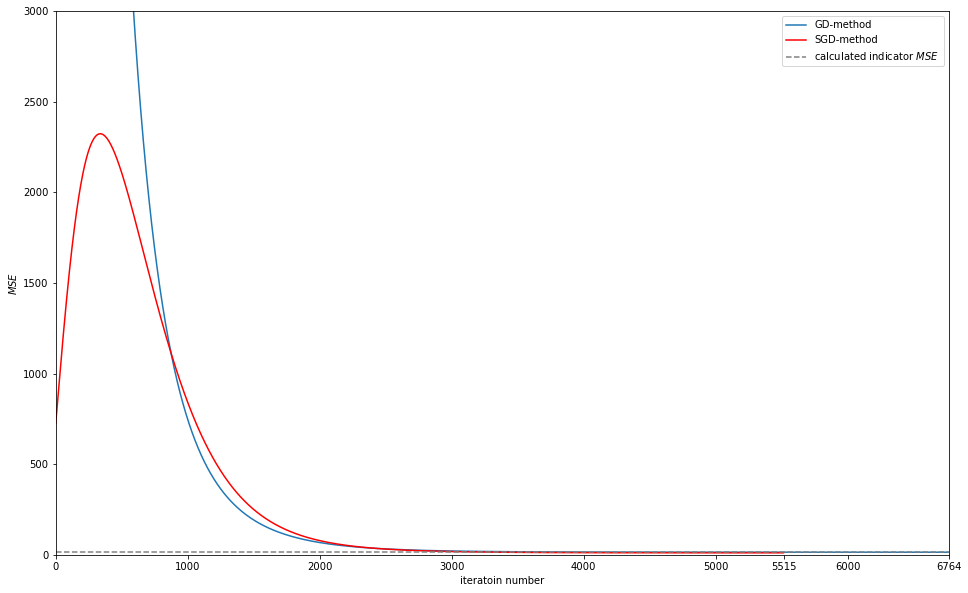

In [21]:
plt.figure(figsize=(16, 10))
plt.ylim((0,3000))
plt.xlim((0,len(score_1)-1000))
plt.plot([x for x in range(len(score_1))], score_1, label='GD-method')
plt.plot([x for x in range(len(score_2))], score_2, c='r', label='SGD-method')
plt.axhline(mse_default, c='gray', ls='--', label=r'calculated indicator $MSE$', mew=0.9)
plt.xlabel('iteratoin number')
plt.xticks(list(plt.xticks()[0])+[len(score_1), len(score_2)])
plt.ylabel(r'$MSE$')
plt.legend()
plt.show()

In [16]:
len(score_2)

5515

На основании графиков можно сделать вывод что примерно до 400-й итерации $SGD$ 'расходился' (значение $MSE$ росло), затем, до уроня 2200 итераций оба алгоритма сходились, при этом скорость схождения $GD$ была выше, чем у $SGD$. Однако затем скорости уравнялись, и $SGD$ сошелся раньше чем $GD$ (5515 итераций против 6764).

### Задание 2

#### Модифицировать решение первого задания путем добавления $L_{2}$-регуляризации (в функцию, считающую MSE добавить норму весов, а в поправку нужно добавить производную для нормы вектора весов по весам) и сравнить результаты.

In [22]:
def euclid(vec):
    norm=0
    for i in vec:
        norm+=i**2
    return norm**0.5

In [23]:
def my_grad_desc_reg(X, y, alpha=1e-04, verbose=False, tol=0.0, lambda_=0.0):

    n = X.shape[0]
    W = np.random.randn(X.shape[1], )  
    min_err = float('inf') 
    n_iter = 0 
    stop_chek = True  
    errors = []  
    while stop_chek:
        n_iter += 1
        y_pred = W @ X.T
        err = calc_mse(y, y_pred)+lambda_*euclid(W)
        errors.append(err)
        if min_err - err > tol:  
            min_err = err
        else: 
            print(
                f'iteration: {n_iter}, weights: {W}, mse: {min_err}')
            stop_chek = False
        W -= alpha * (1 / n * 2 * np.sum(X.T * (y_pred - y), axis=1))+lambda_*W
        if verbose:
            if n_iter % 1000 == 0:
                print(n_iter, W, err)
    return W, min_err, errors

In [24]:
W_3, mse_3, score_3 = my_grad_desc_reg(X, y, alpha=0.001, tol=0.00001, lambda_=0.0000001)

iteration: 6793, weights: [17.01846703 54.46685505  4.75445302 63.30677982 93.39289052 71.0385843
 86.98261453 10.23474703  3.51154994 70.80897092], mse: 14.301652605845172


In [25]:
def my_sgd_reg(X, y, alpha=1e-04, batch_size=1, n_epoch=1e+06, verbose=False, tol=0.0, lambda_=0.0):

    n = X.shape[0]
    W = np.random.randn(X.shape[1], )
    n_batch = n // batch_size
    if n % batch_size != 0:
        n_batch += 1
    min_err = float('inf')
    n_iter = 0
    stop_chek = True
    errors = []
    while stop_chek:
        n_iter += 1
        for b in range(n_batch):
            start_ = batch_size * b
            end_ = batch_size * (b + 1)
            X_tmp = X.T[:, start_: end_]
            y_tmp = y[start_: end_]
            y_pred = W @ X_tmp
            err = calc_mse(y_tmp, y_pred)+lambda_*euclid(W)
            W -= alpha * (1 / n * 2 * (y_pred - y_tmp) @ X_tmp.T)+lambda_*W
        errors.append(err)
        if verbose:
            if n_iter % 1000 == 0:
                print(n_iter, W, err)
        if n_iter==n_epoch:
            print(
                f'n_epoch: {n_iter}, weights: {W}, mse: {min_err}')
            stop_chek = False
        if np.abs(min_err - err) > tol:
            min_err = err if err<=min_err else min_err
        else:
            print(
                f'n_epoch: {n_iter}, weights: {W}, mse: {min_err}')
            stop_chek = False
        
    return W, min_err, errors

In [26]:
W_4, mse_4, score_4 = my_sgd_reg(X, y, alpha=0.001, batch_size=1, n_epoch=8000, tol=0.00001, lambda_=0.0000001)

n_epoch: 5529, weights: [17.03544706 54.27187208  4.6112223  63.01552224 92.74731378 70.9535633
 86.44814867  9.8262736   3.61353508 70.21384851], mse: 14.566307305264383


In [29]:
df=pd.DataFrame(
    {
        'methods':['GD', 'SGD','GD + L2','SGD + L2'],
        r'$\lambda$-coeff':[None,None,0.001,0.001],
        'tol-value': 0.00001,
        'iterations': [len(it) for it in [score_1, score_2, score_3,score_4]],
        'err-value': [it[-1] for it in [score_1, score_2, score_3,score_4]]
    }
)
df

,methods,$\lambda$-coeff,tol-value,iterations,err-value
0,GD,NaN,0.00001,6764,14.301226
1,SGD,NaN,0.00001,5515,10.994688
2,GD + L2,0.001,0.00001,6793,14.301643
3,SGD + L2,0.001,0.00001,5529,14.566297


In [33]:
df2=pd.DataFrame({'GD':W_1, 'SGD':W_2,'GD + L2':W_3,'SGD + L2':W_4}, index=['weigt'+str(i) for i in range(10)])
df2

,GD,SGD,GD + L2,SGD + L2
weigt0,17.018718,17.037556,17.018461,17.035447
weigt1,54.470033,54.523888,54.466833,54.271872
weigt2,4.754319,4.680572,4.754482,4.611222
weigt3,63.309709,63.309124,63.306779,63.015522
weigt4,93.397895,93.325850,93.392918,92.747314
weigt5,71.041461,71.133805,71.038548,70.953563
weigt6,86.985888,86.886510,86.982654,86.448149
weigt7,10.236531,10.126228,10.234790,9.826274
weigt8,3.511173,3.541494,3.511539,3.613535
weigt9,70.812265,70.686322,70.809019,70.213849


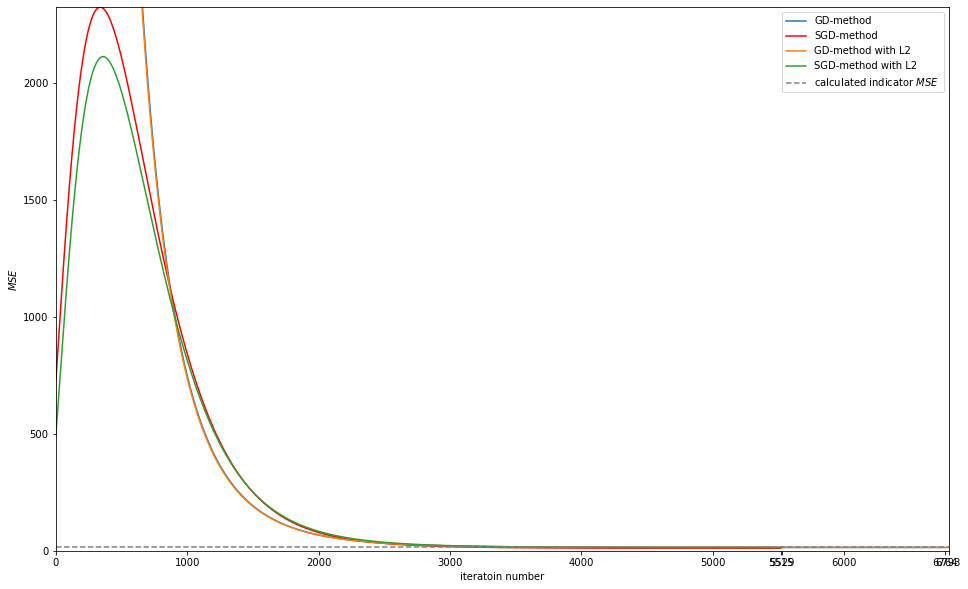

In [31]:
plt.figure(figsize=(16, 10))
plt.ylim((0,np.max([np.max(score_2),np.max(score_4)])))
plt.xlim((0,np.max([len(score_1), len(score_2), len(score_3), len(score_4)])-1000))
plt.plot([x for x in range(1, len(score_1) + 1)], score_1, label='GD-method')
plt.plot([x for x in range(1, len(score_2) + 1)], score_2, c='r', label='SGD-method')
plt.plot([x for x in range(1, len(score_3) + 1)], score_3, label='GD-method with L2')
plt.plot([x for x in range(1, len(score_4) + 1)], score_4, label='SGD-method with L2')
plt.axhline(mse_default, c='gray', ls='--', label=r'calculated indicator $MSE$', mew=0.9)
plt.xticks(list(plt.xticks()[0])+[len(score_1), len(score_2), len(score_3), len(score_4)])
plt.xlabel('iteratoin number')
plt.ylabel(r'$MSE$')
plt.legend()
plt.show()